# Q.1: DOMAIN: Entertainment
## CONTEXT: 
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
### DATA DESCRIPTION: 
The dataset comprises of images and its mask where there is a human face.
### PROJECT OBJECTIVE: Face detection from training images.
## Steps and tasks: [ Total Score: 20 points]
1. Import the dataset.
2. Create features (images) and labels (mask) using that data.
3. Mask detection model:

● Design a face mask detection model.
Hint: Use U-net along with pre-trained transfer learning models
● Design your own Dice Coefficient and Loss function.
● Train, tune and test the model.
● Evaluate the model using testing data.

4. Use the “Prediction image” as an input to your designed model and display the output of the image.
Acknowledgement for the dataset http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/
Mobile Net paper: https://arxiv.org/pdf/1704.04861.pdf

In [1]:
#!pip install tensorflow==2.1.0
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(0)

In [3]:
# Enable GPU in the Colab settings for running the code faster
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [4]:
from zipfile import ZipFile
import os
from tensorflow.keras.models import load_model

## 1. Import the dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/'

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2, os

In [7]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.applications.mobilenet import MobileNet


In [8]:
# Import the dataset from /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Part 1- Train data - images.npy

dataset = np.load(project_path+'Part 1- Train data - images.npy', allow_pickle=True)
dataset.shape

(409, 2)

### Observations
- The dataset has 409 images and same number of labels
- Each label carries the face information for each face detected in the image 
  - label : Face
  - Coordinates : Top left x,y, Bottom right x,y
  - Image Width, Image Height
  

Label: 
 [{'label': ['Face'], 'notes': '', 'points': [{'x': 0.35969664138678226, 'y': 0.23835319609967498}, {'x': 0.600216684723727, 'y': 0.4788732394366197}], 'imageWidth': 1357, 'imageHeight': 1357}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.11700975081256772, 'y': 0.38894907908992415}, {'x': 0.3131094257854821, 'y': 0.5969664138678223}], 'imageWidth': 1357, 'imageHeight': 1357}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.5319609967497292, 'y': 0.6164680390032503}, {'x': 0.7313109425785482, 'y': 0.8548212351029253}], 'imageWidth': 1357, 'imageHeight': 1357}]


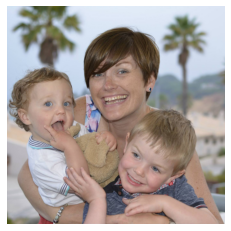

In [9]:
plt.imshow(dataset[400][0])
print('Label: \n', dataset[400][1])
plt.axis('off')
plt.show()

## 2. Create features (images) and labels (mask) using that data

In [10]:
dataset[400][1][0]

{'imageHeight': 1357,
 'imageWidth': 1357,
 'label': ['Face'],
 'notes': '',
 'points': [{'x': 0.35969664138678226, 'y': 0.23835319609967498},
  {'x': 0.600216684723727, 'y': 0.4788732394366197}]}

In [11]:
dataset[400][0].shape

(1357, 1357, 3)

In [12]:
print('Height of the image: ', dataset[400][1][0]['imageHeight'])
print('Width of the image: ' , dataset[400][1][0]['imageWidth'])
print('Label:' , dataset[400][1][0]['label'])
print('Coordinates', dataset[400][1][0]['points'])

Height of the image:  1357
Width of the image:  1357
Label: ['Face']
Coordinates [{'x': 0.35969664138678226, 'y': 0.23835319609967498}, {'x': 0.600216684723727, 'y': 0.4788732394366197}]


In [13]:
images = dataset[:,0]
images.shape

(409,)

In [14]:
labels = dataset[:,1]
labels.shape

(409,)

In [15]:
# Checking for any gray images (2D arrays) present in the dataset
for j, i in enumerate(images):
  if (len(i.shape)<3):
    gray = j
    print('Gray image index number: ', gray)
    #images = np.delete(images, j, axis=0)
#labels = np.delete(labels, j, axis=0)
print(images.shape, labels.shape)

Gray image index number:  272
(409,) (409,)


Label: 
 [{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7907692307692308, 'y': 0.07428571428571429}, {'x': 0.9892307692307692, 'y': 0.5771428571428572}], 'imageWidth': 650, 'imageHeight': 350}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.3707692307692308, 'y': 0.07428571428571429}, {'x': 0.5923076923076923, 'y': 0.5028571428571429}], 'imageWidth': 650, 'imageHeight': 350}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.15384615384615385, 'y': 0.15142857142857144}, {'x': 0.2907692307692308, 'y': 0.36857142857142855}], 'imageWidth': 650, 'imageHeight': 350}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.013846153846153847, 'y': 0.09142857142857143}, {'x': 0.1123076923076923, 'y': 0.3314285714285714}], 'imageWidth': 650, 'imageHeight': 350}]


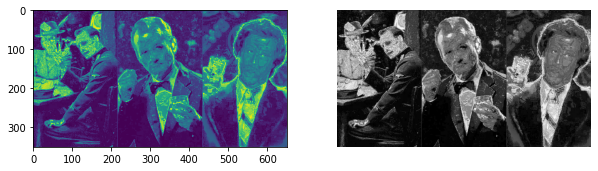

In [16]:
# Visualizing and converting the jth image from GRAY to RGB
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1 )
plt.imshow(dataset[gray][0])
rgb_converted = cv2.cvtColor(dataset[gray][0], cv2.COLOR_GRAY2RGB)
plt.subplot(1, 2, 2)
plt.imshow(rgb_converted)
print('Label: \n', dataset[gray][1])
plt.axis('off')
plt.show()

In [17]:
# Replacing the gray image with rgb converted image
dataset[gray][0] = rgb_converted
print(gray)
dataset[gray][0].shape

272


(350, 650, 3)

In [18]:
# New code for extracting images and masks
from tensorflow.keras.applications.mobilenet import preprocess_input
IMAGE_SIZE = 224
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
MASK_HEIGHT = 28
MASK_WIDTH = 28

masks = np.zeros((int(dataset.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
mask_img = np.zeros((int(dataset.shape[0]), MASK_HEIGHT, MASK_WIDTH))
X = np.zeros((int(dataset.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(dataset.shape[0]):
  img = dataset[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_AREA)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in dataset[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    masks[index][y1:y2, x1:x2] = 1
    mask_img[index] = cv2.resize(masks[index], (28, 28))

print(masks.shape)
print(mask_img.shape)
print(X.shape)

(409, 224, 224)
(409, 28, 28)
(409, 224, 224, 3)


## 3. Mask detection model:

### a) Design a face mask detection model.
Hint: Use U-net along with pre-trained transfer learning models

In [27]:
ALPHA = 1
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

In [28]:
# Example
X[400][100][100]

array([-0.04313725, -0.30196077, -0.27058822])

In [29]:
y = mask_img
print(X.shape)
print(y.shape)

(409, 224, 224, 3)
(409, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


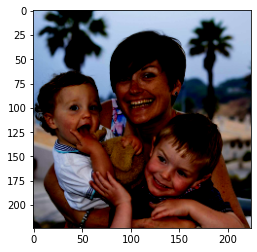

In [30]:
plt.imshow(X[400])

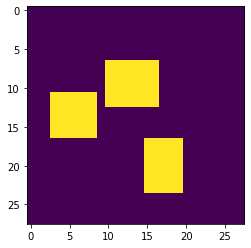

In [31]:
plt.imshow(y[400])

In [33]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(368, 224, 224, 3) (41, 224, 224, 3) (368, 28, 28) (41, 28, 28)


In [34]:
X_train[100][100][0]

array([-0.71764708, -0.78823531, -0.82745099])

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(368, 224, 224, 3) (41, 224, 224, 3) (368, 28, 28) (41, 28, 28)


In [37]:
X_train[100][100][0]

array([-0.71764708, -0.78823531, -0.82745099])

In [38]:
y[400][1][1]

0.0

In [39]:
# Defining a new model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

In [41]:
#base_unet.summary()

### b) Design your own Dice Coefficient and Loss function

In [42]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### c) Train, tune and test the model.


In [43]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

In [44]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss=loss, metrics=[dice_coefficient])

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)
stop = EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [46]:
with tf.device('/device:GPU:0'):
 model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), callbacks=[checkpoint, stop, reduce_lr])

Epoch 1/30
23/23 [==============================] - 22s 878ms/step - loss: 2.3588 - dice_coefficient: 0.2338 - val_loss: 2.0877 - val_dice_coefficient: 0.2287

Epoch 00001: val_loss improved from inf to 2.08769, saving model to model-2.09.h5
Epoch 2/30
23/23 [==============================] - 19s 846ms/step - loss: 2.1113 - dice_coefficient: 0.2183 - val_loss: 1.8440 - val_dice_coefficient: 0.2690

Epoch 00002: val_loss improved from 2.08769 to 1.84398, saving model to model-1.84.h5
Epoch 3/30
23/23 [==============================] - 19s 842ms/step - loss: 1.8186 - dice_coefficient: 0.2682 - val_loss: 1.6493 - val_dice_coefficient: 0.3070

Epoch 00003: val_loss improved from 1.84398 to 1.64928, saving model to model-1.65.h5
Epoch 4/30
23/23 [==============================] - 19s 846ms/step - loss: 1.6861 - dice_coefficient: 0.2890 - val_loss: 1.4955 - val_dice_coefficient: 0.3386

Epoch 00004: val_loss improved from 1.64928 to 1.49549, saving model to model-1.50.h5
Epoch 5/30
23/23 [==

### d) Evaluate the model using testing data

In [47]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 2s 413ms/step - loss: 0.7295 - dice_coefficient: 0.6144


[0.7294846773147583, 0.6143806576728821]

## 4. Use the “Prediction image” as an input to your designed model and display the output of the image.


In [48]:
test_path = project_path + 'Part 1Test Data - Prediction Image.jpeg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


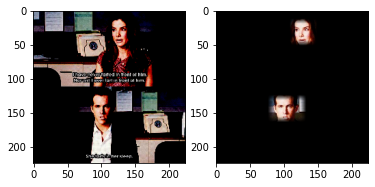

In [49]:
unscaled = cv2.imread(test_path)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.subplot(121)
#plt.suptitle('Prediction Image')
plt.imshow(cv2.cvtColor(feat_scaled, cv2.COLOR_BGR2RGB))
plt.subplot(122)
#plt.suptitle('Detected Face Mask')
plt.imshow(cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2RGB))
#plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.show()

# Q.2: DOMAIN: Entertainment
## CONTEXT: 
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
## TASK: 
Help to create an image dataset to be used by the AI team to build an image classifier data. Profile images of people are given.
1. You are expected to curate the bounding box co-ordinates for each image. These are also called annotations.
2. This task can be done using manual methods where you need to open each image and note the coordinates where the face located [though it is not recommended]. This task can be easily done using an automation where you need to input the image in the automation and the output is the coordinates of the face detected from the image. [this is highly recommended]. Also highlight how many faces detected in each image.
3. Comment on the challenges faced during this task.

Please note: This will require your analytical, research and development skills to try and design the automation required.

Acknowledgement for the dataset: https://www.kaggle.com/ciplab/real-and-fake-face-detection

In [ ]:
# Actual Path /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Part 2 - training images.zip
# Change the path as per your Google drive path
file = project_path + 'Part 2 - training images.zip'

with ZipFile(file, 'r') as zip:
  if (os.path.isdir(project_path + 'training_images')):
    print('Alread extracted data')
  else:
    zip.extractall(project_path)
    print('Extraction done')


Alread extracted data


In [ ]:
# Here we are installing tensorflow version 2.4.0. We need to restart runtime before running the following code:
#!pip install tensorflow==2.4.0
from tensorflow.keras.models import load_model
import tensorflow as tf
tf.__version__

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(0)

In [ ]:
# !ls -lart

In [ ]:
# Install keras-facenet library
!pip install keras-facenet

     |████████████████████████████████| 2.3MB 7.9MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-cp37-none-any.whl size=10386 sha256=a9f711588fb83571f3d7b532a7207d95887c94227f1198b42e5924b357ec5fec
  Stored in directory: /root/.cache/pip/wheels/f6/53/9a/36c4b52fd22faf4f710d5047d874655b85a1b2cf77accfb9bd
Successfully built keras-facenet


In [ ]:
# Import models and initialize
#from keras_facenet import FaceNet
from mtcnn import MTCNN
#embedder = FaceNet()

In [ ]:
# Check face detection for a particular image
filepath = project_path + 'training_images/real_00031.jpg'
# detections = embedder.extract(filepath)

In [ ]:
# Convert the image
from PIL import Image
image = Image.open(filepath)
image = image.convert('RGB')
pixels = np.asarray(image)

In [ ]:
# Initialize MTCNN Detector
detector = MTCNN()

In [ ]:
# Detect face and print results and bounding box details
results = detector.detect_faces(pixels)
print(results)
x1, y1, width, height = results[0]['box']

[{'box': [103, 146, 321, 440], 'confidence': 0.9999990463256836, 'keypoints': {'left_eye': (159, 322), 'right_eye': (294, 324), 'nose': (190, 413), 'mouth_left': (168, 489), 'mouth_right': (272, 492)}}]


In [ ]:
results[0]['box']

[103, 146, 321, 440]

In [ ]:
print(x1, y1, width, height)

103 146 321 440


In [ ]:
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height

In [ ]:
# Create annotations directory for storing the resultant Curated images with bounding boxes around the faces detected
!mkdir Part_2-annotations
dest_path = project_path + 'Part_2-annotations/'

In [ ]:
os.chdir(project_path)
!ls

 facenet_keras.h5
 facenet_keras_weights.h5
'Part 1Test Data - Prediction Image.jpeg'
'Part 1- Train data - images.npy'
 Part_2-annotations
'Part 2 - training images.zip'
'Part 3 - Aligned Face Dataset from Pinterest.zip'
'Part 3 - vgg_face_weights.h5'
'Part 4 Video.zip'
 training_images


(600, 600, 3)
Face Detected
X coordinate:  103
Y coordinate:  146
Height:  440
Width:  321


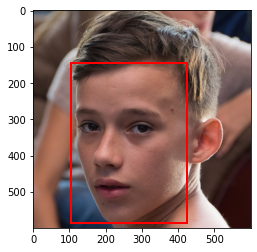

In [ ]:
# Drawing a bounding box on a sample image using patch
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
unscaled = plt.imread(filepath, cv2.COLOR_BGR2RGB)
ax.imshow(unscaled)
print(unscaled.shape)
rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print('Face Detected')
print('X coordinate: ', x1)
print('Y coordinate: ', y1)
print('Height: ', height)
print('Width: ', width)
plt.show()

In [ ]:
def detect_face(filename):
  image = Image.open(filename)
  image = image.convert('RGB')
  pixels = np.asarray(image)
  results = detector.detect_faces(pixels)
  return results

In [ ]:
train_path = project_path + 'training_images/'

filepaths = []
for file in os.listdir(train_path):
  path = train_path + file
  filepaths.append(path)
print('Number of files: ', len(filepaths))

Number of files:  1091


In [ ]:
with tf.device('/device:GPU:0'):
  results = np.array(list(map(detect_face, filepaths)))
print(results.shape)

(1091,)


In [ ]:
results[0]

[{'box': [86, 92, 371, 474],
  'confidence': 0.999998927116394,
  'keypoints': {'left_eye': (153, 298),
   'mouth_left': (164, 464),
   'mouth_right': (301, 449),
   'nose': (191, 366),
   'right_eye': (304, 281)}}]

In [ ]:
#fetch_coord = lambda result: result[0]['box']
#coords = np.array(list(map(fetch_coord, results)))

In [ ]:
# Extracting coordinates and height, width information from the results list array
i = 0
junk = []
coords = []
for r in results:
  if (r):
    coords.append(r[0]['box'])
  else:
    coords.append([0, 0, 0, 0])  # For images where detector couldn't detect a face correctly
    junk.append(i)
  i += 1
#print(i)
print('Number of coordinates extracted: ', len(coords))

Number of coordinates extracted:  1091


In [ ]:
# Here's how a sample result looks like
results[1032]

[]

In [ ]:
# filepaths contain the full path of the file from root directory
filepaths[0:5]

['/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/training_images/real_01023.jpg',
 '/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/training_images/real_00997.jpg',
 '/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/training_images/real_00956.jpg',
 '/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/training_images/real_01069.jpg',
 '/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/training_images/real_00992.jpg']

In [ ]:
# We need to extract filenames from filepaths to create the currated files and store them at a different location
filenames = []
for p in filepaths:
  name = p.split('/')
  filenames.append(name[8])
print(len(filenames))

1091


In [ ]:
# short_paths = filepaths[0:5]
# short_files = filenames[0:5]

In [ ]:
import itertools
#zip = ZipFile()
i = 0
for path,file in itertools.zip_longest(filepaths, filenames):
#  with open(path, mode='r') as f:
  img = cv2.imread(path)
  x1, y1, w, h = coords[i]
  i += 1
  #print(x1, y1, w, h)
  cv2.rectangle(img, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
  f = dest_path + file
  cv2.imwrite(f, img)
  if (i==1091):
    print('Bounding Box creation done on all images!')
    print('The new images are stored in ', dest_path)

Bounding Box creation done on all images!
The new images are stored in  /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Part_2-annotations/


Original Image Path is at  /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/training_images/real_00100.jpg
Curated image with bounding box is at  /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Part_2-annotations/real_00100.jpg
Face Detected
X coordinate:  123
Y coordinate:  77
Height:  345
Width:  483


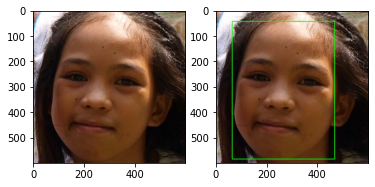

In [ ]:
# Visualizing the original and curated image side by side
name = 'real_00100.jpg'
#coordinates = coords[100]
x1, y1, height, width = coords[100]
plt.subplots(1,2)
old = train_path + name
print('Original Image Path is at ', old)
old = Image.open(old)
plt.subplot(1,2,1)
plt.imshow(old)
old.close()

new = dest_path + name
print('Curated image with bounding box is at ', new)
new = Image.open(new)
plt.subplot(1,2,2)
plt.imshow(new)
new.close()

print('Face Detected')
print('X coordinate: ', x1)
print('Y coordinate: ', y1)
print('Height: ', height)
print('Width: ', width)
plt.show()

# Q.3: • DOMAIN: Face recognition
## CONTEXT: 
Company X intends to build a face identification model to recognise human faces.
### DATA DESCRIPTION: 
The dataset comprises of images and its mask where there is a human face.
## PROJECT OBJECTIVE: 
Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.
## TASK: 
In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project.

1) Load the dataset and create the metadata.

2) Check some samples of metadata.

3) Load the pre-trained model and weights.

4) Generate Embedding vectors for each face in the dataset.

5) Build distance metrics for identifying the distance between two given images.

6) Use PCA for dimensionality reduction.

7) Build an SVM classifier to map each image to its right person.

8) Predict using the SVM model.

Instructions for all the above steps are given in the notebook.


## 1) Load the dataset and create the metadata.


In [ ]:
# Actual Path /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Part 3 - Aligned Face Dataset from Pinterest.zip
# Change the path as per your Google drive path
file = project_path + 'Part 3 - Aligned Face Dataset from Pinterest.zip'

with ZipFile(file, 'r') as zip:
  if (os.path.isdir(project_path + 'PINS')):
    print('Alread extracted data')
  else:
    zip.extractall(project_path)
    print('Extraction done')


Alread extracted data


In [ ]:
os.chdir(project_path)
!ls

 facenet_keras.h5
 facenet_keras_weights.h5
'Part 1Test Data - Prediction Image.jpeg'
'Part 1- Train data - images.npy'
 Part_2-annotations
'Part 2 - training images.zip'
'Part 3 - Aligned Face Dataset from Pinterest.zip'
'Part 3 - vgg_face_weights.h5'
'Part 4 Video.zip'
 pins
 PINS
 training_images


In [ ]:
pins_path = project_path + 'PINS/'

In [ ]:
# Define an Identity class to identify the metadata of a particular person
IMAGE_SIZE = 224

class IdentityMetadata():
  def __init__(self, base, name, file):
    # Database directory
    self.base = base
    # Identity name
    self.name = name
    # Image file name
    self.file = file
  
  def __repr__(self):
    return self.image_path()
  
  def image_path(self):
    return os.path.join(self.base, self.name, self.file)

# Define a function to load metadata from a given path
def load_metadata(path):
  metadata = []
  for i in sorted(os.listdir(path)):
    for f in sorted(os.listdir(os.path.join(path, i))):
      # Check file extension, allow only jpg/jpeg files
      ext = os.path.splitext(f)[1]
      if (ext == '.jpg' or ext == '.jpeg'):
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

with tf.device('/device:GPU:0'):
  metadata = load_metadata(pins_path)



In [ ]:
print('Metadata shape' , metadata.shape)

Metadata shape (10770,)


## 2) Check some samples of metadata.


In [ ]:
print('Print a few metadata information \n', metadata[100:105])

Print a few metadata information 
 [/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/PINS/pins_Alvaro Morte/Alvaro Morte144_795.jpg
 /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/PINS/pins_Alvaro Morte/Alvaro Morte145_862.jpg
 /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/PINS/pins_Alvaro Morte/Alvaro Morte146_860.jpg
 /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/PINS/pins_Alvaro Morte/Alvaro Morte146_861.jpg
 /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/PINS/pins_Alvaro Morte/Alvaro Morte14_817.jpg]


In [ ]:
print('Name in the metadata \n', metadata[100].name)

Name in the metadata 
 pins_Alvaro Morte


In [ ]:
def load_image(path):
  img = cv2.imread(path, 1)
  # OpenCV loads images with color channels in BGR order. So, need to reverse them
  return img[..., ::-1]

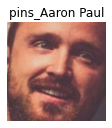

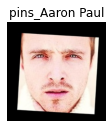

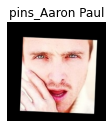

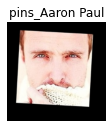

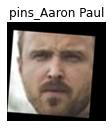

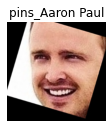

In [ ]:
#plt.figure(figsize=(10,10))
#fig = plt.subplots(1, 3)
for i in range(6):
  img = load_image(metadata[i].image_path())
  img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
  plt.subplot(2, 3, i+1)
  plt.imshow(img.astype('uint8'))
  plt.title(metadata[i].name)
  #print(img.shape)
  plt.axis('off')
  plt.show()

## 3) Load the pre-trained model and weights.


In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-vy7_i6k4
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-vy7_i6k4
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=322e2b3ffd76b44ee4f3f22adc3e2bfd699ccfa8db1194affecc76c027a468d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-btxgc8c7/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
!pip install keras_applications

In [ ]:
!pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: pyyaml, h5py, pillow, six, scipy, numpy, keras
Required-by: 


In [ ]:
import keras_vggface
print(keras_vggface.__version__)

0.6


In [ ]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras  import Model
model_vggface = VGGFace(model='vgg16', weights=None, include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(model_vggface.inputs)
print(model_vggface.outputs)
model_vggface.summary()

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>]
[<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'pool5')>]
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D) 

In [ ]:
model_vggface.load_weights(project_path + 'Part 3 - vgg_face_weights.h5', by_name=True)

In [ ]:
model_vggface.layers[-1].output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'pool5')>

In [ ]:
new_model = Model(inputs=model_vggface.layers[0].input, outputs=model_vggface.layers[-1].output )

In [ ]:
added = tf.keras.layers.Flatten()(new_model.layers[-1].output)
output = tf.keras.layers.Dense(128,)(added)
final_model = Model(inputs=new_model.layers[0].input, outputs=output)
final_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

## 4) Generate Embedding vectors for each face in the dataset.



In [ ]:
#from tensorflow.keras.applications.vgg16 import preprocess_input
from keras_vggface.utils import preprocess_input, decode_predictions
import timeit

In [ ]:
from PIL import Image
def read_image(path):
  with Image.open(path) as img:
    img_np = np.array(img) 
    img_np = img_np[..., ::-1]
    return img_np

In [ ]:
test = read_image(metadata[0].image_path())
test.shape

(301, 299, 3)

In [ ]:
%%time
IMAGE_SIZE = 224
embeddings = np.zeros((metadata.shape[0], 128))
images = []

with tf.device('/device:GPU:0'):
  for i, m in enumerate(metadata):
    img = read_image(m.image_path())
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    #img = img.astype('float32')
    img = (img / 255.0).astype('float32')
    #img = preprocess_input(img, data_format='float32', version=1)
    #images.append(img)
    embeddings[i] = final_model.predict(np.expand_dims(img, axis=0))


CPU times: user 7min 18s, sys: 1min 5s, total: 8min 24s
Wall time: 8min 26s


In [ ]:
img[1][0]

array([0.4627451, 0.5254902, 0.5764706], dtype=float32)

In [ ]:
embeddings.shape

(10770, 128)

In [ ]:
metadata.shape

(10770,)

In [ ]:
embeddings.shape

(10770, 128)

## 5) Build distance metrics for identifying the distance between two given images.



In [ ]:
def distance(emb1, emb2):
  emb1 = emb1.astype('float32')
  emb2 = emb2.astype('float32')
  return np.sum(np.square(emb1 - emb2))

In [ ]:
# Test the distance function
e1 = embeddings[1]
e2 = embeddings[2]
print(distance(e1, e2))

0.33920947


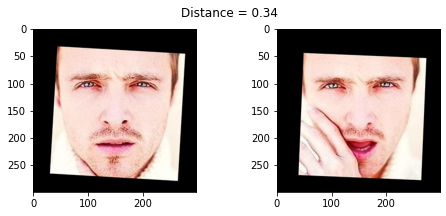

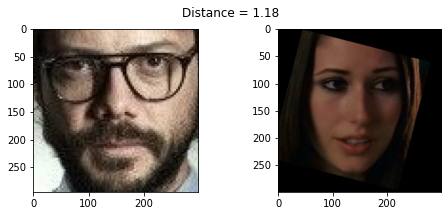

In [ ]:
def display_pair(id1, id2):
  plt.figure(figsize=(8,3))
  plt.suptitle(f'Distance = {distance(embeddings[id1], embeddings[id2]):.2f}')
  plt.subplot(121)
  plt.imshow(load_image(metadata[id1].image_path()))
  plt.subplot(122)
  plt.imshow(load_image(metadata[id2].image_path()));
  
display_pair(1, 2)
display_pair(100, 200)

In [ ]:
# Create a custom scorer for SVM
from sklearn.metrics import make_scorer

In [ ]:
myScorer = make_scorer(distance,   greater_is_better=False)

## 6) Use PCA for dimensionality reduction.



In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=32)
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_

array([0.04322769, 0.02581868, 0.02325197, 0.01995579, 0.01836983,
       0.01608077, 0.01593779, 0.01412838, 0.01357865, 0.01249064,
       0.01161418, 0.01081355, 0.01054643, 0.01035099, 0.0097099 ,
       0.00931656, 0.00901612, 0.00881307, 0.00832438, 0.00799605,
       0.00750948, 0.00728986, 0.00710225, 0.00708019, 0.00691613,
       0.00657163, 0.00642922, 0.00608263, 0.00581581, 0.00557426,
       0.00545976, 0.00537695])

In [ ]:
embeddings.max()

0.41772225499153137

In [ ]:
embeddings.min()

-0.45779740810394287

In [ ]:
embeddings.mean()

-0.004155918196564676

In [ ]:
print(pca.explained_variance_ratio_)

[0.0687226  0.04104607 0.03696557 0.03172535 0.02920403 0.02556492
 0.0253376  0.02246104 0.02158709 0.0198574  0.01846401 0.01719119
 0.01676653 0.01645582 0.01543662 0.01481129 0.01433366 0.01401086
 0.01323395 0.01271197 0.01193843 0.01158928 0.01129103 0.01125596
 0.01099514 0.01044746 0.01022105 0.00967005 0.00924587 0.00886186
 0.00867983 0.00854817]


In [ ]:
pca_emb = pca.transform(embeddings)

In [ ]:
# Shape of the resultant X variable
pca_emb.shape

(10770, 32)

In [ ]:
f = lambda x: x.name
names = np.array(list(map(f, metadata)))
names.shape

(10770,)

## 7) Build an SVM classifier to map each image to its right person.



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_emb, names, random_state=0, test_size=0.3, shuffle=True )

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7539, 32) (3231, 32) (7539,) (3231,)


In [ ]:
# Print first 5 Names to confirm that the data has been shuffled
print(y_train[:5])
print(y_test[:5])

['pins_alycia debnam carey face' 'pins_Amanda Crew' 'pins_Jason Momoa'
 'pins_Maisie Williams' 'pins_Emilia Clarke']
['pins_alycia debnam carey face' 'pins_Jesse Eisenberg'
 'pins_david mazouz' 'pins_barbara palvin face' 'pins_Gwyneth Paltrow']


In [ ]:
# Now lets fit the SVM classifier
svm = SVC()
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Let's check the accuracy of SVM face detection model using the Facenet embeddings
svm.score(X_test, y_test)

0.8409161250386877

## 8) Predict using the SVM model.

In [ ]:
# Predict all the images
y_pred = svm.predict(X_test)

In [ ]:
print('Let us compare a sample prediction with the ground truth\n')
i = 1001
print('Predicted face: ', y_pred[i])
print('Ground Truth: ', y_test[i])

Let us compare a sample prediction with the ground truth

Predicted face:  pins_brie larson
Ground Truth:  pins_brie larson


# Q.4: DOMAIN: State traffic department
## CONTEXT: 
City X’s traffic department wants to understand the traffic density on road during busy hours in order to efficiently program their traffic lights.
## TASK: 
Create an automation using computer vision to impute dynamic bounding boxes to locate cars or vehicles on the road. It would require for you to do some research on how to impute bounding boxes on video file. You can use video provided with this assignment or any video of your choice which has moving cars to impute bounding boxes.


In [50]:
project_path

'/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/'

In [51]:
# Actual Path /content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Part 4 Video.zip
# Change the path as per your Google drive path
videos_zip = project_path + 'Part 4 Video.zip'

with ZipFile(videos_zip, 'r') as zip:
  if (os.path.isdir(project_path + 'Video')):
    print('Alread extracted data')
  else:
    zip.extractall(project_path)
    print('Extraction done')

Alread extracted data


In [52]:
!ls /content/drive/MyDrive/Colab/Computer\ Vision/CNN-2nd-Project/Video/

video1_imputed.mp4.avi	video1.mp4  video2.mp4


In [53]:
videos = []
for files in os.listdir(project_path+'Video'):
  #print(files)
  f = files.split(sep='.')
  if (f[1]=='mp4'):
    print(files)
    #videos.append(files)
    path = os.path.join(project_path+'Video', files)
    videos.append(path)
print(videos)

video1.mp4
video2.mp4
video1_imputed.mp4.avi
['/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Video/video1.mp4', '/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Video/video2.mp4', '/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project/Video/video1_imputed.mp4.avi']


In [54]:
train_video = cv2.VideoCapture(videos[0])
test_video = cv2.VideoCapture(videos[1])

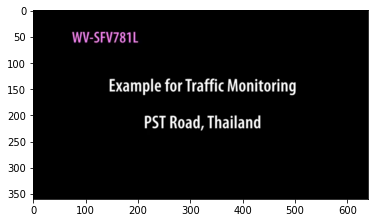

In [55]:
while(True):
  # read the training video frame by frame
  ret, frame = train_video.read()

  v = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  plt.imshow(v)
  if (cv2.waitKey(1)):
    break

train_video.release()
cv2.destroyAllWindows()

In [56]:
# Set the current directory to the poject path
os.chdir(project_path)
os.getcwd()

'/content/drive/MyDrive/Colab/Computer Vision/CNN-2nd-Project'

In [57]:
# Download the yolov3 Object detection model
if (os.path.isfile('yolov3.h5')):
  print('Yolov3 model file already downloaded')
else:
  !wget https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo.h5 -O yolov3.h5

Yolov3 model file already downloaded


In [58]:
# # Download the Weights
# if (os.path.isfile('yolov3.weights')):
#   print('Yolov3 Weights already downloaded')
# else:
#   !wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights

In [59]:
# yolo = load_model('yolov3.h5')
# yolo.summary()

In [60]:
# yolo.load_weights('yolov3.weights')
# yolo.summary()

In [62]:
#!pip install tensorflow==2.4.0
!pip install imageai

In [63]:
# Import VideoObjectDetection library from imageai
from imageai.Detection import VideoObjectDetection

path = os.getcwd()
print(path)
detector = VideoObjectDetection()

# Set the Model type as Yolov3
detector.setModelTypeAsYOLOv3()

# Load Yolov3 Model from the downloaded path
detector.setModelPath(os.path.join(path, 'yolov3.h5'))
detector.loadModel()

/content/drive/My Drive/Colab/Computer Vision/CNN-2nd-Project


In [64]:
# Run object detection using the pre-trained Yolov3 model to imputed the output video file
with tf.device('/device:GPU:0'):
  video_path = detector.detectObjectsFromVideo(input_file_path=videos[0], output_file_path=os.path.join(project_path+'Video', 'video1_imputed.mp4'), 
                                             frames_per_second=29, log_progress=True)
print(video_path)

Processing Frame :  1
Processing Frame :  2
Processing Frame :  3
Processing Frame :  4
Processing Frame :  5
Processing Frame :  6
Processing Frame :  7
Processing Frame :  8
Processing Frame :  9
Processing Frame :  10
Processing Frame :  11
Processing Frame :  12
Processing Frame :  13
Processing Frame :  14
Processing Frame :  15
Processing Frame :  16
Processing Frame :  17
Processing Frame :  18
Processing Frame :  19
Processing Frame :  20
Processing Frame :  21
Processing Frame :  22
Processing Frame :  23
Processing Frame :  24
Processing Frame :  25
Processing Frame :  26
Processing Frame :  27
Processing Frame :  28
Processing Frame :  29
Processing Frame :  30
Processing Frame :  31
Processing Frame :  32
Processing Frame :  33
Processing Frame :  34
Processing Frame :  35
Processing Frame :  36
Processing Frame :  37
Processing Frame :  38
Processing Frame :  39
Processing Frame :  40
Processing Frame :  41
Processing Frame :  42
Processing Frame :  43
Processing Frame :  